In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [2]:
# Create the tools
 
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the ...'}]

In [3]:
llm_with_tools = llm.bind_tools(tools)
llm= llm_with_tools


In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [24]:
graph_builder = StateGraph(State)

In [25]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [26]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools=[tool])

In [27]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

In [28]:
graph_builder.set_entry_point("chatbot")


### This is not needed since we do not want to always end from chatbot. We end only via the conditional edge


In [ ]:
# graph_builder.set_finish_point("chatbot")

In [30]:
graph_builder.add_edge("tools", "chatbot")

In [31]:
graph_builder.add_conditional_edges("chatbot",tools_condition)

In [32]:
graph = graph_builder.compile()

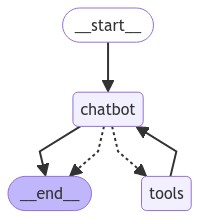

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [34]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"url": "https://www.wsj.com/market-data/quotes/TSLA", "content": "The Wall Street Journal\nTesla Inc.\nNewsTesla Inc.TSLA\nKey Stock Data\nShort Interest (11/15/23)\nStock Money Flow\nN/A\nResearch & Ratings\nTesla Inc.(TSLA)\nPer-Share Earnings, Actuals and Estimates\nFinancials\nTesla Inc.(TSLA)\nCOMPETITORS (TSLA)\nPROFILE (TSLA)\nTesla, Inc. engages in the design, development, manufacture, and sale of fully electric vehicles and energy generation and storage systems. FactSet (a) does not make any express or implied warranties of any kind regarding the data, including, without limitation, any warranty of merchantability or fitness for a particular purpose or use; and (b) shall not be liable for any errors, incompleteness, interruption or delay, action taken in reliance on any data, or for any damages resulting therefrom. Change value during the period between open outcry settle and the commencement of the next day's trading is calculated as the difference be